In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import hilbert
import pickle
from matplotlib.ticker import MultipleLocator

In [2]:
with open("tq_2classes_Session4.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))

for key in data.keys():
    print(key)

marker_data = data['markers']

rest_marker = data["calibration_rest_mrks"]
print(rest_marker)

for num in marker_data:
    num = int(num) 
    print(num)  

diffs = [b - a for a, b in zip(marker_data, marker_data[1:])]
abs_diffs = [abs(d)/250 for d in diffs] 
print(abs_diffs)

classes = data['class']
print(classes)  

<class 'dict'>
data
markers
class
calibration_blink_mrks
calibration_rest_mrks
[3190, 4512]
11005
12929
14853
16777
18700
20654
22578
24483
26407
28330
30254
32178
34094
36013
37920
39844
41768
43691
45581
47505
49429
51377
53301
55147
57071
58995
60919
62843
64766
66690
68670
70587
72465
74338
76245
78244
80168
82092
84016
85939
[7.696, 7.696, 7.696, 7.692, 7.816, 7.696, 7.62, 7.696, 7.692, 7.696, 7.696, 7.664, 7.676, 7.628, 7.696, 7.696, 7.692, 7.56, 7.696, 7.696, 7.792, 7.696, 7.384, 7.696, 7.696, 7.696, 7.696, 7.692, 7.696, 7.92, 7.668, 7.512, 7.492, 7.628, 7.996, 7.696, 7.696, 7.696, 7.692]
[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]


In [3]:
eeg_data = data['data']
print(type(eeg_data))
channels, samples = eeg_data.shape
print(f'Channels: {channels}, Samples: {samples}')

SAMPLING_FREQUENCY = 250  # Hz


# for chan in range(channels):
#     channel_data = eeg_data[chan, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]
#     print(f'Channel {chan} data shape: {channel_data.shape}')
#     time_axis = np.linspace(0, 2, len(channel_data))
#     plt.figure()
#     plt.plot(time_axis, channel_data)
#     plt.title(f'Channel {chan} EEG Data around Marker 20')
#     plt.grid()
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude (µV)')
#     plt.show()

# real_data = eeg_data[6, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]

<class 'numpy.ndarray'>
Channels: 8, Samples: 88220


In [ ]:
plt.figure()
plt.plot(time_axis, real_data)
plt.grid()
plt.show()

In [ ]:
plt.figure()
offset = 0 
plt.plot(np.fft.rfftfreq(len(real_data), 1/SAMPLING_FREQUENCY)[offset:], np.abs(np.fft.rfft(real_data))[offset:])

plt.xlabel("Frequency [Hz]")
plt.grid()
plt.title("Frequency Spectrum from FFT")

In [ ]:
spline_methode = 'akima'  # 'linear', 'cubic_hermite', 'akima', 'quadratic'
fixe = 10 # 0 to run with the default stopping criterion

emd_analyser = EMD(spline_kind= spline_methode,
                   #extrema_detection='simple',
                   MAX_ITERATION=12,
                   #IXE=fixe,
                   #FIXEH=0
                   )

IMFs = emd_analyser.emd(real_data, time_axis
                        #, max_imf= -1
                        ) # can be used with raw_signal or modified_signal
num_imfs = IMFs.shape[0] + 1

plt.figure(figsize=(30, 30))

plt.subplot(num_imfs, 1, 1)
plt.plot(time_axis, real_data) # can be used with raw_signal or modified_signal
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"Original Raw EEG Signal")
ax = plt.gca()

# for plotting the IMFs
for idx, IMF in enumerate(IMFs):
    plt.subplot(num_imfs, 1, idx+2)
    plt.plot(time_axis, IMF)
    plt.grid()
    plt.title(f"IMF {idx+1}, spline: {spline_methode}, fixe = {fixe}")
    ax = plt.gca()
    
plt.tight_layout()
plt.show()

# Plotting the fft for each IMF
plt.figure(figsize=(20, 20))
freq_axis = np.fft.rfftfreq(len(time_axis),1/SAMPLING_FREQUENCY)
for idx, IMF in enumerate(IMFs):
    plt.subplot(num_imfs, 1, idx+1)
    IMF_fft = np.abs(np.fft.rfft(IMF))
    plt.plot(freq_axis, IMF_fft)
    plt.grid()
    plt.xlabel("frequency [Hz]")
    plt.ylabel('Amplitude')
    plt.title(f"FFT of IMF {idx+1}")
    ax = plt.gca()
plt.show()

# Plotting the IF with hilbert transform for each IMF
plt.figure(figsize=(20, 20))
for idx, IMF in enumerate(IMFs):
    plt.subplot(num_imfs, 1, idx+1)
    hilbert_signal = hilbert(IMF)
    instantaneous_amplitude = np.abs(hilbert_signal)
    instantaneous_phase = np.unwrap(np.angle(hilbert_signal))
    instantaneous_frequency = np.gradient(instantaneous_phase) / (2.0*np.pi) * SAMPLING_FREQUENCY

    plt.plot(time_axis, instantaneous_frequency,  label="IF")
    plt.plot(time_axis, instantaneous_amplitude, 'r', label='IA')
    plt.legend()
    plt.grid()
    plt.xlabel("Time [s]")
    plt.ylabel('IF, IA')
    plt.title(f"IMF {idx+1}")
    ax = plt.gca()
plt.show()

# Removing the first IMF which is the noice from the power grid


In [ ]:
denoiced_signal = real_data - IMFs[0]
 
plt.figure(figsize=(30, 10))
plt.plot(time_axis, denoiced_signal) # can be used with raw_signal or modified_signal
plt.plot(time_axis, real_data, alpha=0.5, label='Original Signal')
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude')
plt.title(f"Original vs denoiced Signal") 

In [ ]:
spline_methode = 'akima'  # 'linear', 'cubic_hermite', 'akima', 'quadratic'
fixe = 10 # 0 to run with the default stopping criterion

emd_analyser = EMD(spline_kind= spline_methode,
                   #extrema_detection='simple',
                   MAX_ITERATION=12,
                   #IXE=fixe,
                   #FIXEH=0
                   )

IMFs = emd_analyser.emd(denoiced_signal, time_axis
                        #, max_imf= -1
                        )
num_imfs = IMFs.shape[0] + 1

plt.figure(figsize=(30, 30))

plt.subplot(num_imfs, 1, 1)
plt.plot(time_axis, denoiced_signal) # can be used with raw_signal or modified_signal
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"Original Raw EEG Signal")
ax = plt.gca()

# for plotting the IMFs
for idx, IMF in enumerate(IMFs):
    plt.subplot(num_imfs, 1, idx+2)
    plt.plot(time_axis, IMF)
    plt.grid()
    plt.title(f"IMF {idx+1}, spline: {spline_methode}, fixe = {fixe}")
    ax = plt.gca()
    
plt.tight_layout()
plt.show()

# Plotting the fft for each IMF
plt.figure(figsize=(20, 20))
freq_axis = np.fft.rfftfreq(len(time_axis),1/SAMPLING_FREQUENCY)
for idx, IMF in enumerate(IMFs):
    plt.subplot(num_imfs, 1, idx+1)
    IMF_fft = np.abs(np.fft.rfft(IMF))
    plt.plot(freq_axis, IMF_fft)
    plt.grid()
    plt.xlabel("frequency [Hz]")
    plt.ylabel('Amplitude')
    plt.title(f"FFT of IMF {idx+1}")
    ax = plt.gca()
plt.show()

# Plotting the IF with hilbert transform for each IMF
plt.figure(figsize=(20, 20))
for idx, IMF in enumerate(IMFs):
    plt.subplot(num_imfs, 1, idx+1)
    hilbert_signal = hilbert(IMF)
    instantaneous_amplitude = np.abs(hilbert_signal)
    instantaneous_phase = np.unwrap(np.angle(hilbert_signal))
    instantaneous_frequency = np.gradient(instantaneous_phase) / (2.0*np.pi) * SAMPLING_FREQUENCY

    plt.plot(time_axis, instantaneous_frequency,  label="IF")
    plt.plot(time_axis, instantaneous_amplitude, 'r', label='IA')
    plt.legend()
    plt.grid()
    plt.xlabel("Time [s]")
    plt.ylabel('IF, IA')
    plt.title(f"IMF {idx+1}")
    ax = plt.gca()
plt.show()

In [ ]:
masking_frequency = 130
masking_amplitude = 75
masking_signal = masking_amplitude*np.sin(2*np.pi*masking_frequency*time_axis)

added_signal = real_data + masking_signal
subtracted_signal = real_data - masking_signal

spline_methode = 'akima'  # 'linear', 'cubic_hermite', 'akima', 'quadratic'
fixe = 10 # 0 to run with the default stopping criterion

emd_analyser = EMD(spline_kind= spline_methode,
                   #extrema_detection='simple',
                   MAX_ITERATION=12,
                   #FIXE=fixe,
                   #FIXEH=0
                   )

IMFs = emd_analyser.emd(added_signal, time_axis, max_imf= -1) # can be used with raw_signal or modified_signal
num_imfs = IMFs.shape[0] + 1

IMFs_sub = emd_analyser.emd(subtracted_signal, time_axis, max_imf= -1) # can be used with raw_signal or modified_signal

plt.figure(figsize=(20, 20))

plt.subplot(num_imfs, 1, 1)
plt.plot(time_axis, added_signal) # can be used with raw_signal or modified_signal
plt.plot(time_axis, subtracted_signal)
plt.plot(time_axis, real_data, 'k')
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"Added and subtracted with a {masking_frequency} Hz sinus and amplitude {masking_amplitude}")
ax = plt.gca()

# for plotting the IMFs
for idx, IMF in enumerate(IMFs):
    for idx_sub, IMF_sub in enumerate(IMFs_sub):
        if idx == idx_sub:
            plt.subplot(num_imfs, 1, idx+2)
            plt.plot(time_axis, (IMF+IMF_sub)/2)
            plt.grid()
            plt.title(f"IMF {idx+1}, spline: {spline_methode}, fixe = {fixe}")
            ax = plt.gca()
        
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 20))

plt.subplot(num_imfs, 1, 1)
plt.plot(time_axis, added_signal) # can be used with raw_signal or modified_signal
plt.plot(time_axis, subtracted_signal)
plt.plot(time_axis, real_data, 'k')
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"Added and subtracted with a {masking_frequency} Hz sinus and amplitude {masking_amplitude}")
ax = plt.gca()

# for plotting the IMFs
for idx, IMF in enumerate(IMFs):
    for idx_sub, IMF_sub in enumerate(IMFs_sub):
        if idx == idx_sub:
            plt.subplot(num_imfs, 1, idx+2)
            fft_IMF = np.abs(np.fft.rfft((IMF+IMF_sub)/2))
            freq_axis = np.fft.rfftfreq(len(time_axis),1/SAMPLING_FREQUENCY)
            plt.plot( freq_axis, fft_IMF)
            plt.grid()
            plt.title(f"IMF {idx+1}, spline: {spline_methode}, fixe = {fixe}, fft")
            ax = plt.gca()
    
        
plt.tight_layout()
plt.show()

# Alysing the signal using MEMD


In [4]:
from plot_styles import *
from MEMD_all import memd

In [5]:


channel_1 = eeg_data[0, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]
channel_2 = eeg_data[1, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]
channel_3 = eeg_data[2, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]
channel_4 = eeg_data[3, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]
channel_5 = eeg_data[4, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]
channel_6 = eeg_data[5, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]
channel_7 = eeg_data[6, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]
channel_8 = eeg_data[7, marker_data[20] - SAMPLING_FREQUENCY :  marker_data[20] + SAMPLING_FREQUENCY]

data = np.array([channel_1, channel_2, channel_3, channel_4, channel_5, channel_6, channel_7, channel_8])
print(type(data))
print(data.shape)


<class 'numpy.ndarray'>
(8, 500)


In [6]:
IMFs = memd(data,16)

In [7]:
print(IMFs.shape)
print(type(IMFs))

(9, 8, 500)
<class 'numpy.ndarray'>


In [ ]:
IMF_ch1 = IMFs[:, 0, :]
print(type(IMF_ch1))
print(IMF_ch1.shape)

plt.figure(figsize=(30, 30))

plt.subplot(IMF_ch1.shape[0]+1, 1, 1)
plt.plot(time_axis, channel_1) 
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"channel 1 Original Raw EEG Signal")
ax = plt.gca()

# for plotting the IMFs
for i in range(IMF_ch1.shape[0]):
    plt.subplot(10, 1, i+2)
    plt.plot(time_axis, IMF_ch1[i, :])
    plt.grid()
    plt.title(f"IMF {i+1} for chennel 1")
    ax = plt.gca()
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 20))
freq_axis = np.fft.rfftfreq(len(time_axis),1/SAMPLING_FREQUENCY)
for i in range(IMF_ch1.shape[0]):
    plt.subplot(9, 1, i+1)
    IMF_fft = np.abs(np.fft.rfft(IMF_ch1[i, :]))
    plt.plot(freq_axis, IMF_fft)
    plt.grid()
    plt.xlabel("frequency [Hz]")
    plt.ylabel('Amplitude')
    plt.title(f"FFT of IMF {i+1} for channel 1")
    ax = plt.gca()
plt.show()


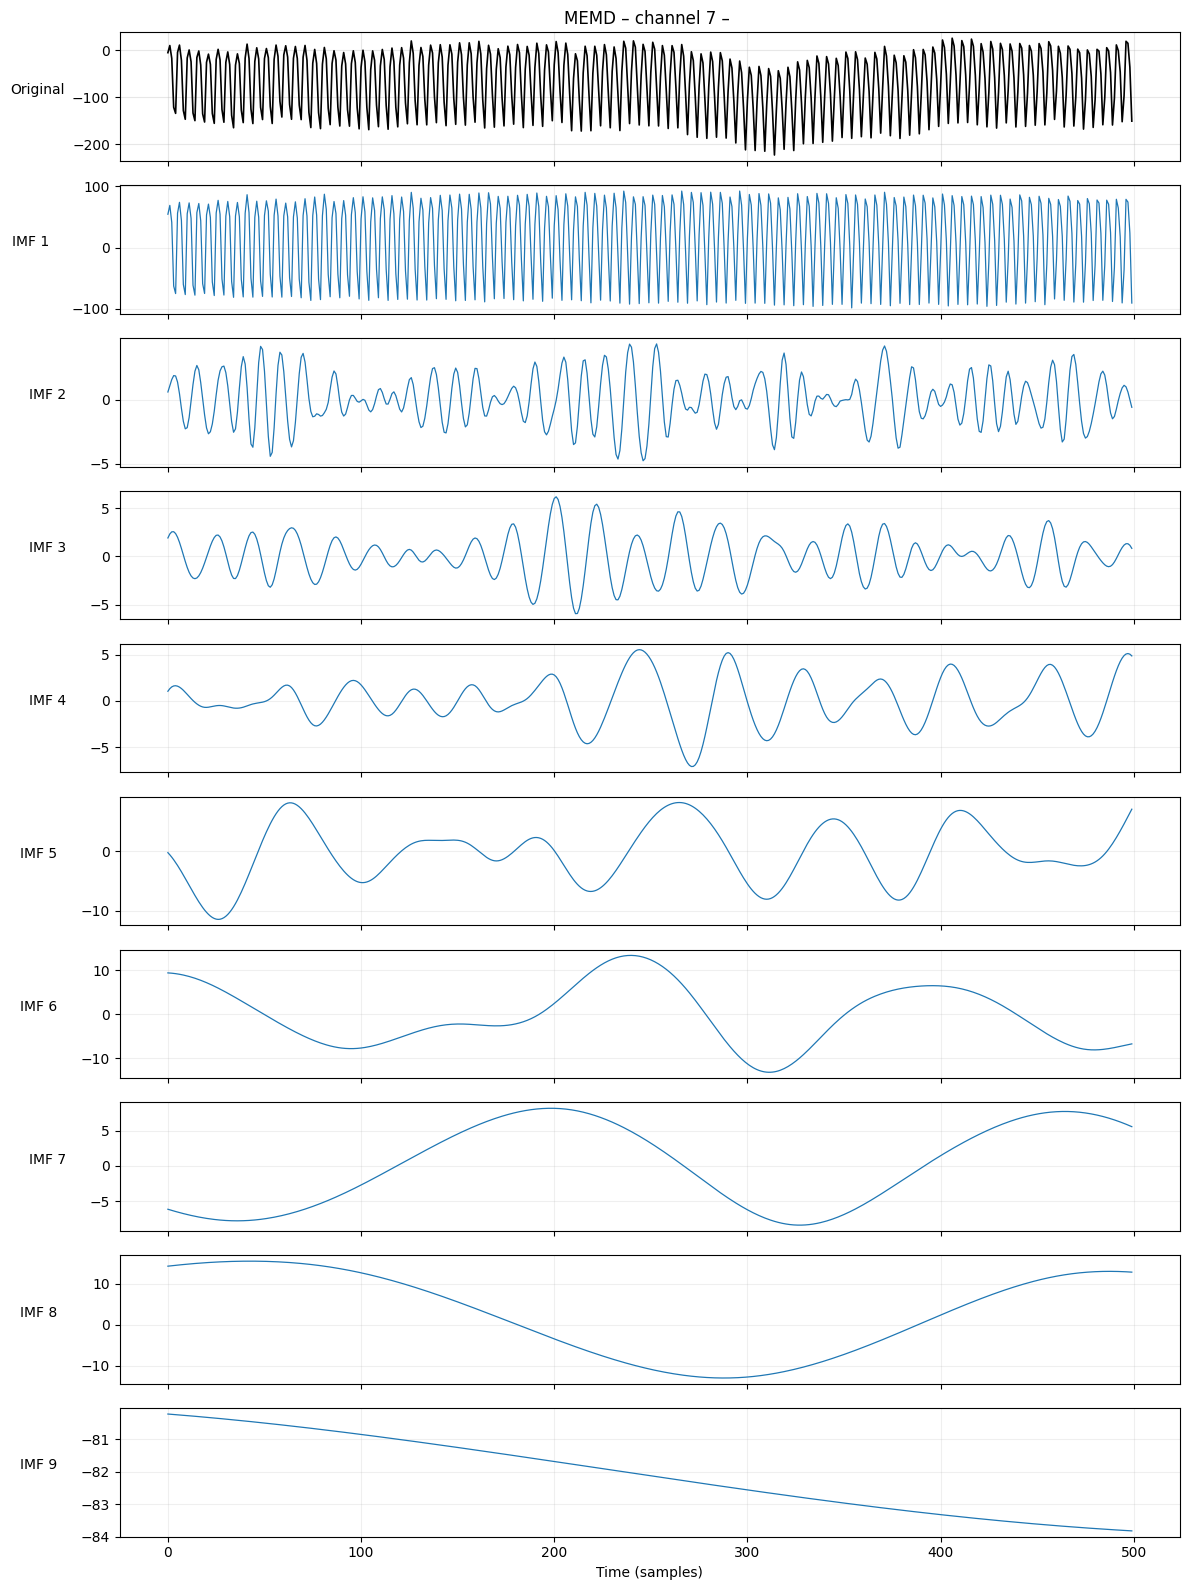

In [7]:
plot_imfs(data,IMFs, method_name="MEMD", roi_idx=6)

In [ ]:
plot_imfs_with_spectrum(data,IMFs, method_name="MEMD", roi_idx=6, fs=SAMPLING_FREQUENCY, fmax=SAMPLING_FREQUENCY/2)

(9, 8, 500)
(9, 8, 500)


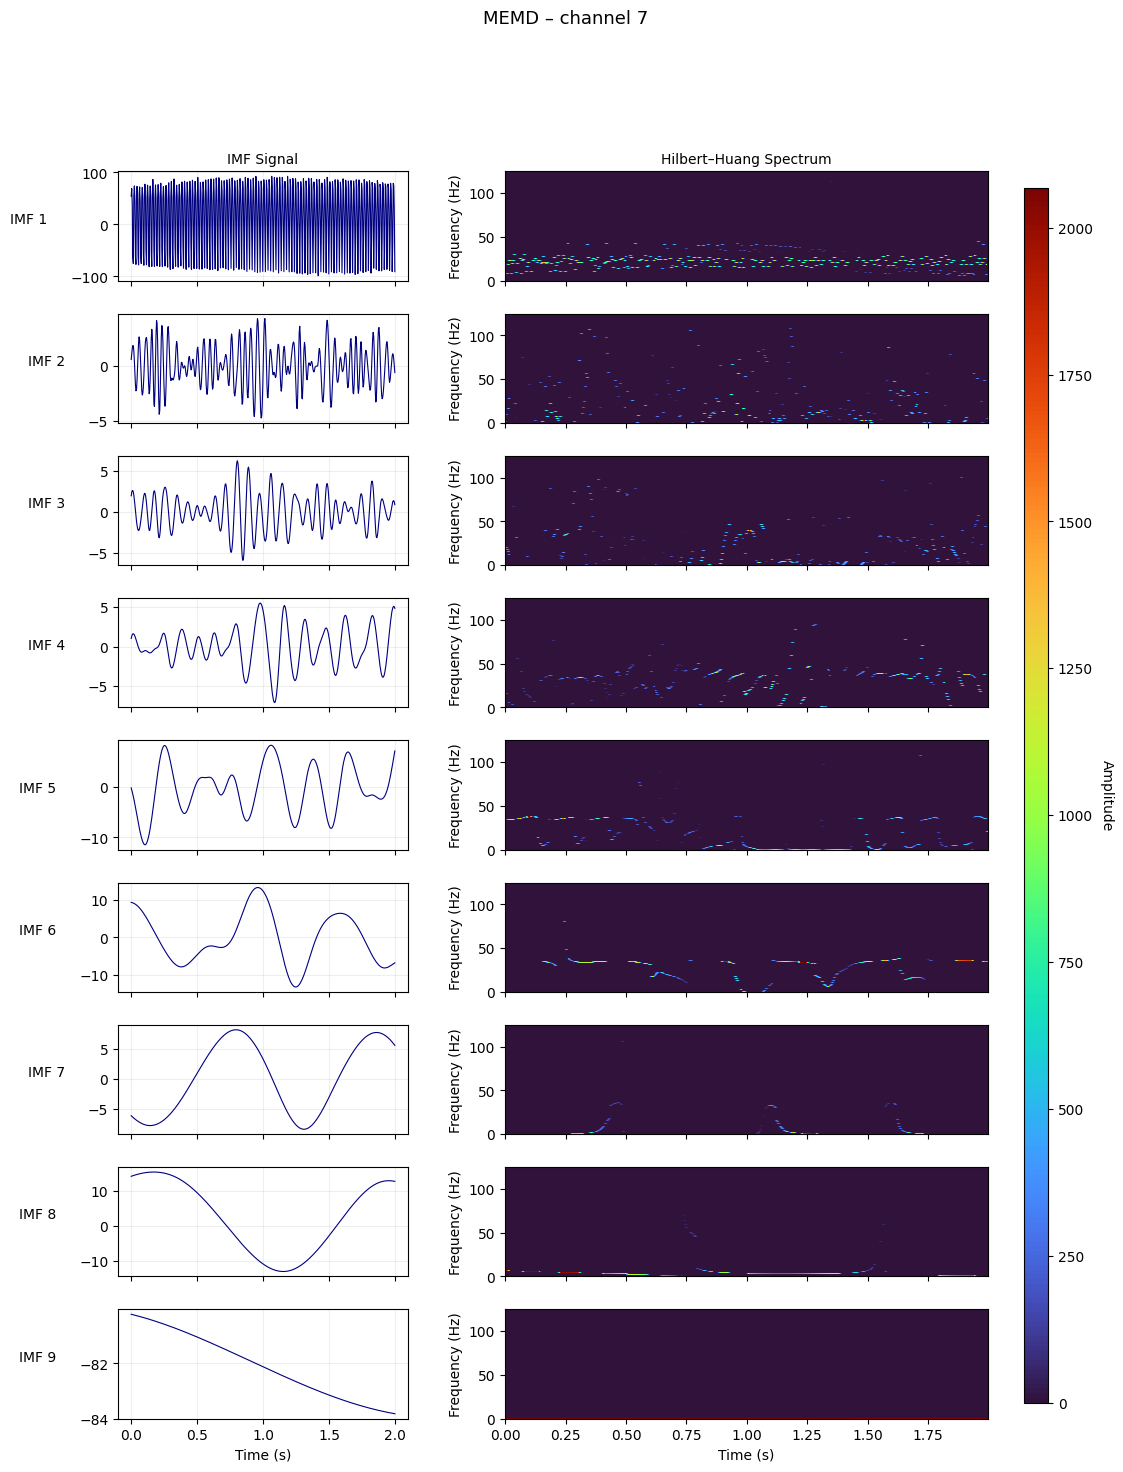

In [8]:
inst_amp, inst_freq = compute_hht(IMFs, fs=250, smooth_sigma=1)

print(inst_amp.shape)
print(inst_freq.shape)

plot_imfs_with_hht(IMFs, inst_amp, inst_freq, method_name="MEMD", roi_idx=6, fs = SAMPLING_FREQUENCY, fmax=SAMPLING_FREQUENCY/2)

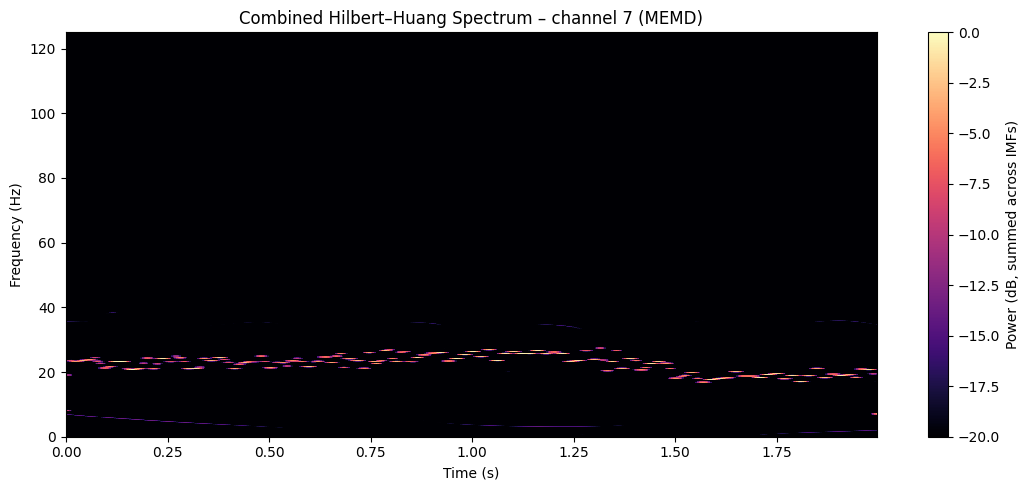

In [9]:
plot_combined_hht(inst_amp, inst_freq, method_name="MEMD", roi_idx=6, fs = SAMPLING_FREQUENCY, fmax=SAMPLING_FREQUENCY/2, imf_keep=(0,9))

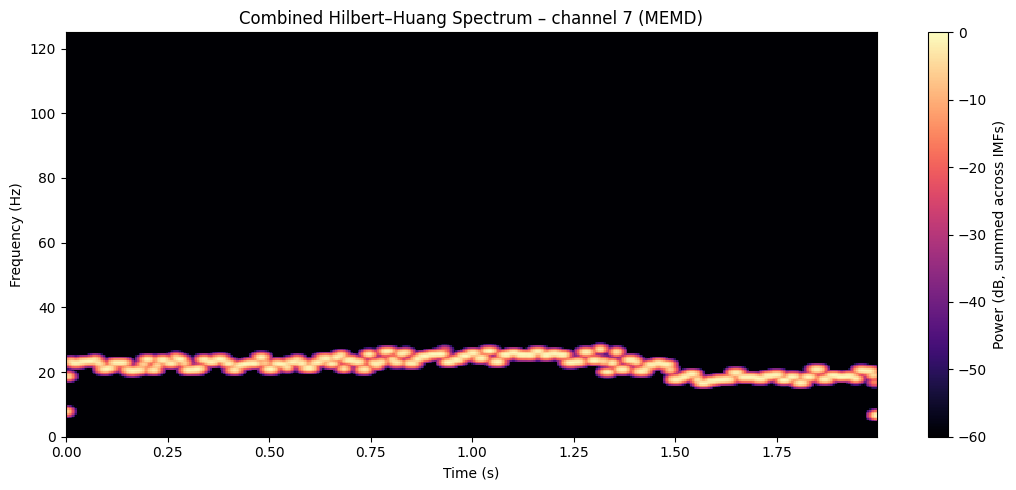

In [17]:
plot_combined_hht(inst_amp, inst_freq, method_name="MEMD", roi_idx=6, fs = SAMPLING_FREQUENCY, fmax=SAMPLING_FREQUENCY/2, imf_keep=(0,1))

In [ ]:
IMF_ch2 = IMFs[:, 1, :]
print(type(IMF_ch2))
print(IMF_ch2.shape)

plt.figure(figsize=(30, 30))

plt.subplot(IMF_ch2.shape[0]+1, 1, 1)
plt.plot(time_axis, channel_2) 
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"channel 2 Original Raw EEG Signal")
ax = plt.gca()

# for plotting the IMFs
for i in range(IMF_ch2.shape[0]):
    plt.subplot(10, 1, i+2)
    plt.plot(time_axis, IMF_ch2[i, :])
    plt.grid()
    plt.title(f"IMF {i+1} for chennel 2")
    ax = plt.gca()
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 20))
freq_axis = np.fft.rfftfreq(len(time_axis),1/SAMPLING_FREQUENCY)
for i in range(IMF_ch2.shape[0]):
    plt.subplot(9, 1, i+1)
    IMF_fft = np.abs(np.fft.rfft(IMF_ch2[i, :]))
    plt.plot(freq_axis, IMF_fft)
    plt.grid()
    plt.xlabel("frequency [Hz]")
    plt.ylabel('Amplitude')
    plt.title(f"FFT of IMF {i+1} for channel 2")
    ax = plt.gca()
plt.show()



In [ ]:
IMF_ch3 = IMFs[:, 2, :]
print(type(IMF_ch3))
print(IMF_ch3.shape)

plt.figure(figsize=(30, 30))

plt.subplot(IMF_ch3.shape[0]+1, 1, 1)
plt.plot(time_axis, channel_3) 
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"channel 3 Original Raw EEG Signal")
ax = plt.gca()

# for plotting the IMFs
for i in range(IMF_ch3.shape[0]):
    plt.subplot(10, 1, i+2)
    plt.plot(time_axis, IMF_ch3[i, :])
    plt.grid()
    plt.title(f"IMF {i+1} for chennel 3")
    ax = plt.gca()
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 20))
freq_axis = np.fft.rfftfreq(len(time_axis),1/SAMPLING_FREQUENCY)
for i in range(IMF_ch3.shape[0]):
    plt.subplot(9, 1, i+1)
    IMF_fft = np.abs(np.fft.rfft(IMF_ch3[i, :]))
    plt.plot(freq_axis, IMF_fft)
    plt.grid()
    plt.xlabel("frequency [Hz]")
    plt.ylabel('Amplitude')
    plt.title(f"FFT of IMF {i+1} for channel 3")
    ax = plt.gca()
plt.show()

In [ ]:
IMF_ch4 = IMFs[:, 3, :]
print(type(IMF_ch4))
print(IMF_ch4.shape)

plt.figure(figsize=(30, 30))

plt.subplot(IMF_ch4.shape[0]+1, 1, 1)
plt.plot(time_axis, channel_4) 
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"channel 4 Original Raw EEG Signal")
ax = plt.gca()

# for plotting the IMFs
for i in range(IMF_ch4.shape[0]):
    plt.subplot(10, 1, i+2)
    plt.plot(time_axis, IMF_ch4[i, :])
    plt.grid()
    plt.title(f"IMF {i+1} for chennel 4")
    ax = plt.gca()
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 20))
freq_axis = np.fft.rfftfreq(len(time_axis),1/SAMPLING_FREQUENCY)
for i in range(IMF_ch4.shape[0]):
    plt.subplot(9, 1, i+1)
    IMF_fft = np.abs(np.fft.rfft(IMF_ch4[i, :]))
    plt.plot(freq_axis, IMF_fft)
    plt.grid()
    plt.xlabel("frequency [Hz]")
    plt.ylabel('Amplitude')
    plt.title(f"FFT of IMF {i+1} for channel 4")
    ax = plt.gca()
plt.show()

In [ ]:
IMF_ch7 = IMFs[:, 6, :]
print(type(IMF_ch7))
print(IMF_ch7.shape)

plt.figure(figsize=(30, 30))

plt.subplot(IMF_ch7.shape[0]+1, 1, 1)
plt.plot(time_axis, channel_7) 
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel('Amplitude [V]')
plt.title(f"channel 7 Original Raw EEG Signal")
ax = plt.gca()

# for plotting the IMFs
for i in range(IMF_ch7.shape[0]):
    plt.subplot(10, 1, i+2)
    plt.plot(time_axis, IMF_ch7[i, :])
    plt.grid()
    plt.title(f"IMF {i+1} for chennel 7")
    ax = plt.gca()
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 20))
freq_axis = np.fft.rfftfreq(len(time_axis),1/SAMPLING_FREQUENCY)
for i in range(IMF_ch7.shape[0]):
    plt.subplot(9, 1, i+1)
    IMF_fft = np.abs(np.fft.rfft(IMF_ch7[i, :]))
    plt.plot(freq_axis, IMF_fft)
    plt.grid()
    plt.xlabel("frequency [Hz]")
    plt.ylabel('Amplitude')
    plt.title(f"FFT of IMF {i+1} for channel 7")
    ax = plt.gca()
plt.show()

# Now we will try using the VMED

In [ ]:
import numpy as np
from pysdkit import MVMD
from pysdkit import VMD



In [ ]:
vmd = VMD(alpha=560, K=8, tau=0.0, tol=1e-9)

IMFs = vmd.fit_transform(signal = channel_7)

vmd.plot_IMFs(save_figure=False)

# Now we try with the MVMD

In [ ]:
mvmd = MVMD(alpha=500, K=9, tau=0.0, tol=1e-9)

IMFs = mvmd.fit_transform(signal = data)

print(IMFs.shape)

In [ ]:
plt.figure(figsize=(30, 30))
for i in range(IMFs.shape[0]):
    plt.subplot(9, 1, i+1)
    plt.plot(time_axis, IMFs[i, :, 1])
    plt.grid()
    plt.title(f"IMF {i+1} for chennel 1")
    ax = plt.gca()
    
plt.tight_layout()
plt.show()